# Structure of the Notebook


**4. Feature Engineering**

**5. Mode Building**

    5.1 Benchmark Model
    5.2 Linear Regression
    5.3 Decision Tree
    

In [51]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [52]:
path = '/Users/aishwaryasingh/PuzzleSchedulingProject/puzzle-scheduling/data/'
df = pd.read_csv(path+'members_packs_cleaned.csv')

## 4. Feature Engineering

In [54]:
# taking code from job's branch
pieces_by_difficulty = []

for i, row in df.iterrows():
    out = {
        'name': row['pack_name'],
        'pieces_d1': 0,
        'pieces_d2': 0,
        'pieces_d3': 0,
        'pieces_d4': 0,
        'num_puzzles': row['num_puzzles']
    }
    
    if not math.isnan(row['piece_count_1']):
        out[f'pieces_d{str(int(row["difficulty_rating_1"]))}'] += row['piece_count_1']
    
    if(row['num_puzzles'] == 2 and math.isnan(row['piece_count_1']) == False):
        out[f'pieces_d{str(int(row["difficulty_rating_2"]))}'] += row['piece_count_2']
        
    pieces_by_difficulty.append(out)

In [55]:
pieces_df = pd.DataFrame(pieces_by_difficulty)
pieces_df.head()

,name,pieces_d1,pieces_d2,pieces_d3,pieces_d4,num_puzzles
0,Artifact Puzzles Justin Hillgrove Word Travels...,456,548,0,0,2
1,Artifact Puzzles Justin Hillgrove Word Travels...,456,548,0,0,2
2,Artifact Puzzles Justin Hillgrove Word Travels...,456,548,0,0,2
3,Artifact Puzzles Justin Hillgrove Word Travels...,456,548,0,0,2
4,Artifact Puzzles Justin Hillgrove Word Travels...,456,548,0,0,2


In [56]:
# making things at pack level
for i in range(0, len(df)):
    if df['num_puzzles'][i] ==1:
        pass
    else:
        df['piece_count_1'][i] = df['piece_count_1'][i] + df['piece_count_2'][i]
        df['difficulty_rating_1'][i] = (df['difficulty_rating_1'][i] + df['difficulty_rating_2'][i])//2

In [57]:
df_final = pd.concat([df, pieces_df], axis=1)

In [58]:
df_final.head(2)

,memberID,holdtime,pack_name,piece_count_1,piece_count_2,difficulty_rating_1,difficulty_rating_2,brand_2,brand_1,num_puzzles,name,pieces_d1,pieces_d2,pieces_d3,pieces_d4,num_puzzles
0,member1,2.939411,Artifact Puzzles Justin Hillgrove Word Travels...,1004,548,1,2,Artifact,Artifact,2,Artifact Puzzles Justin Hillgrove Word Travels...,456,548,0,0,2
1,member17,17.904266,Artifact Puzzles Justin Hillgrove Word Travels...,1004,548,1,2,Artifact,Artifact,2,Artifact Puzzles Justin Hillgrove Word Travels...,456,548,0,0,2


In [59]:
df_final.drop(['name', 'piece_count_2', 'difficulty_rating_2', 'num_puzzles'], axis=1, inplace = True)

In [60]:
df_final.shape, df.shape, pieces_df.shape

((16671, 11), (16671, 10), (16671, 6))

### 4.1 Separating test set to avoid data leakage

In [61]:
from sklearn.model_selection import train_test_split

In [62]:
# splitting data
train, test = train_test_split(df_final, test_size = 0.25, random_state=1)

### 4.2 member level features

In [64]:
train.head()

,memberID,holdtime,pack_name,piece_count_1,difficulty_rating_1,brand_2,brand_1,pieces_d1,pieces_d2,pieces_d3,pieces_d4
1250,member3,1.737623,Artifact Puzzles Isabelle Plante La Connaissan...,737,1,Artifact,Artifact,737,0,0,0
6267,member530,14.006373,Ecru Puzzles Angela Gomes Monets Garden Ecru P...,569,1,Ecru,Ecru,355,214,0,0
1325,member238,12.187903,Nautilus Puzzles Mandala Stones,432,3,Nautilus,Nautilus,0,0,432,0
11418,member34,11.115203,Stumpcraft Melissa McKinnon Bursting Blooms Wh...,695,3,Other-Laser-cut,Other-Laser-cut,0,0,695,0
10544,member235,17.075080,Nervous System Rainbow Puzzle Nervous System E...,821,2,Other-Laser-cut,Other-Laser-cut,380,0,0,441


In [63]:
# average hold time at member level
member_avg_holdtime = train[['memberID', 'holdtime']].groupby(by = ['memberID']).mean()
member_avg_holdtime.columns = ['avg_holdtime']

In [67]:
# global average hold time - will be later used for fillna
train_holdtime_mean = train['holdtime'].mean()
train_holdtime_mean

16.233853376004497

In [68]:
train_merged = train.merge(member_avg_holdtime, on = 'memberID', how = 'left')

### 4.3 pack level features

In [65]:
train_merged.head()

,holdtime,piece_count_1,difficulty_rating_1,brand_2,brand_1,pieces_d1,pieces_d2,pieces_d3,pieces_d4,avg_holdtime
0,1.737623,737,1,Artifact,Artifact,737,0,0,0,23.837801
1,14.006373,569,1,Ecru,Ecru,355,214,0,0,26.545537
2,12.187903,432,3,Nautilus,Nautilus,0,0,432,0,19.920049
3,11.115203,695,3,Other-Laser-cut,Other-Laser-cut,0,0,695,0,27.899476
4,17.075080,821,2,Other-Laser-cut,Other-Laser-cut,380,0,0,441,20.459168


In [66]:
# average hold time at pack level
pack_avg_holdtime = train[['pack_name', 'holdtime']].groupby(by = ['pack_name']).mean()
pack_avg_holdtime.columns = ['pack_avg_holdtime']

In [69]:
train_merged = train_merged.merge(pack_avg_holdtime, on = 'pack_name', how = 'left')

In [70]:
train_merged.drop(['memberID', 'pack_name'], axis=1, inplace=True)

## 5. Model Building

In [71]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn import tree

In [72]:
x_train = train_merged.drop('holdtime', axis=1)
y_train = train_merged['holdtime']

### 5.0 Test set need the same features

In [73]:
test_merged = test.merge(member_avg_holdtime, on = 'memberID', how = 'left')

In [76]:
test_merged = test_merged.merge(pack_avg_holdtime, on = 'pack_name', how = 'left')

In [78]:
test_merged.isnull().sum()

memberID                0
holdtime                0
pack_name               0
piece_count_1           0
difficulty_rating_1     0
brand_2                 0
brand_1                 0
pieces_d1               0
pieces_d2               0
pieces_d3               0
pieces_d4               0
avg_holdtime           18
pack_avg_holdtime       6
dtype: int64

In [80]:
test_merged['avg_holdtime'].fillna(train_holdtime_mean, inplace=True)
test_merged['pack_avg_holdtime'].fillna(train_merged['pack_avg_holdtime'].mean(), inplace=True)

In [85]:
test_merged.drop(['memberID', 'pack_name'], axis=1, inplace = True)
x_test = test_merged.drop('holdtime', axis = 1)
y_test = test_merged['holdtime']

### 5.1 Benchmark Model

In [86]:
# First just try average hold time by member
train_holdtime_mean = y_train.mean()

In [87]:
pred1 = np.empty(len(y_test)) 
pred1.fill(train_holdtime_mean)

mean_absolute_error(y_test, pred1)

12.2585659897474

### 5.2 Linear Regression

In [88]:
x_train.dtypes

piece_count_1            int64
difficulty_rating_1      int64
brand_2                 object
brand_1                 object
pieces_d1                int64
pieces_d2                int64
pieces_d3                int64
pieces_d4                int64
avg_holdtime           float64
pack_avg_holdtime      float64
dtype: object

In [89]:
x_train.shape, x_test.shape

((12503, 10), (4168, 10))

In [90]:
# dummy variable - hopefully x_test doesnt bring any surprises
x_train = pd.get_dummies(x_train)
x_test = pd.get_dummies(x_test)
x_train.shape, x_test.shape

((12503, 28), (4168, 28))

In [91]:
x_test.head()

,piece_count_1,difficulty_rating_1,pieces_d1,pieces_d2,pieces_d3,pieces_d4,avg_holdtime,pack_avg_holdtime,brand_2_Artifact,brand_2_DaVici,...,brand_1_Artifact,brand_1_DaVici,brand_1_Ecru,brand_1_Liberty,brand_1_Nautilus,brand_1_Other-Hand-cut,brand_1_Other-Laser-cut,brand_1_Stave,brand_1_Wentworth,brand_1_unknown
0,313,2,0,313,0,0,11.292932,9.488180,1,0,...,1,0,0,0,0,0,0,0,0,0
1,861,3,0,0,861,0,17.427163,15.321017,0,0,...,1,0,0,0,0,0,0,0,0,0
2,852,1,852,0,0,0,10.809319,14.417597,1,0,...,1,0,0,0,0,0,0,0,0,0
3,729,2,0,729,0,0,11.797654,7.062908,0,0,...,0,0,0,1,0,0,0,0,0,0
4,522,2,0,522,0,0,19.920049,16.936139,0,0,...,0,0,0,0,1,0,0,0,0,0


In [92]:
# simple linear regression
model = LinearRegression(normalize=True)
model.fit(x_train, y_train)  #fit the model
pred2 = model.predict(x_test) #make prediction on test set

In [93]:
mean_absolute_error(y_test, pred2) #calculate mae

10.0156240485335

### 5.3 Decision Tree

In [94]:
def dtree_grid_search(X,y,nfolds):
    #create a dictionary of all values we want to test
    param_grid = {'max_depth': [3, 5, 7, 9]}
    # decision tree model
    dtree_model = DecisionTreeRegressor()
    #use gridsearch to test all values
    dtree_gscv = GridSearchCV(dtree_model, param_grid, cv=nfolds)
    #fit model to data
    dtree_gscv.fit(X, y)
    return dtree_gscv.best_params_

In [95]:
dtree_grid_search(X = x_train, y = y_train, nfolds = 5)

{'max_depth': 5}

In [96]:
model_dt = DecisionTreeRegressor(max_depth = 5,random_state=0)
model_dt.fit(x_train, y_train)  #fit the model
pred3 = model_dt.predict(x_test) #make prediction on test set

In [97]:
mean_absolute_error(y_test, pred3) #calculate mae

10.021442706958428

In [98]:
fn = x_train.columns

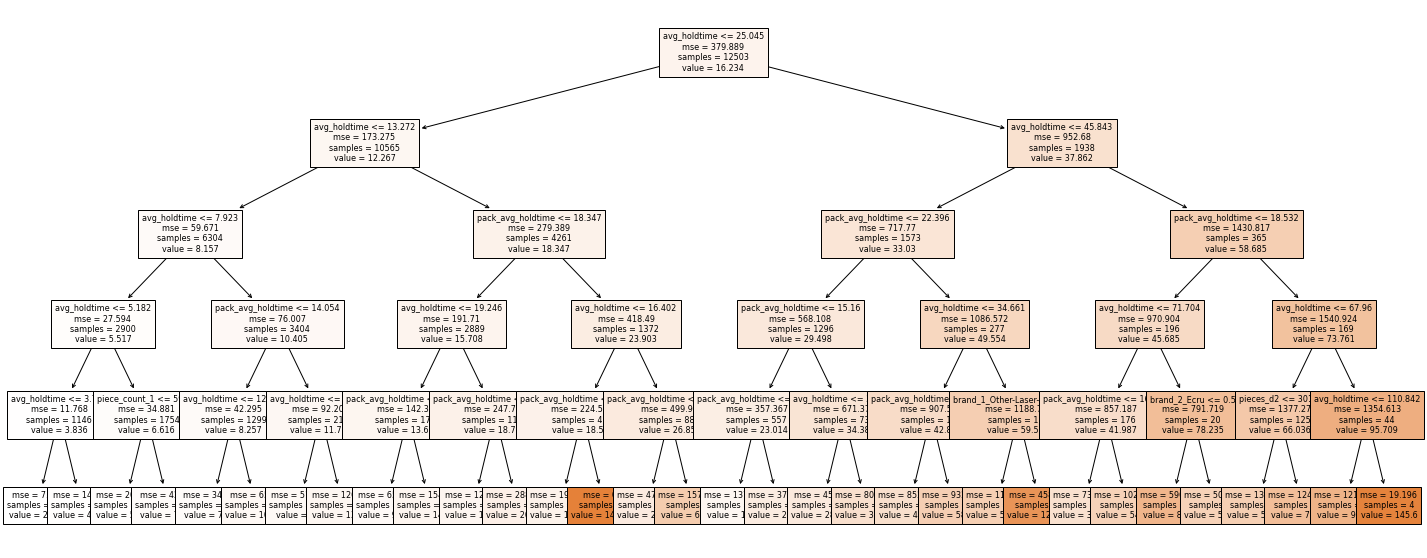

In [99]:
plt.figure(figsize=(25,10))
tree.plot_tree(model_dt, feature_names = fn, filled = True, fontsize=8);
plt.savefig('imagename.png')

In [100]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(x_train.columns, model_dt.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
# importances.sort_values(by='Gini-importance').plot(kind='bar', rot=45)

In [104]:
importances.sort_values(by = 'Gini-importance', ascending=False)

,Gini-importance
avg_holdtime,0.821691
pack_avg_holdtime,0.165223
pieces_d2,0.005364
brand_1_Other-Laser-cut,0.004331
brand_2_Ecru,0.002139
piece_count_1,0.001251
brand_2_Wentworth,0.000000
brand_1_Wentworth,0.000000
brand_1_Stave,0.000000
brand_1_Other-Hand-cut,0.000000
